In [1]:
import pandas as pd
from copy import deepcopy
import copy
import math as math
import numpy as np
from matplotlib import pyplot as plt
import time, os, sys, json,pickle
from math import exp
import itertools
from smart_open import open

# Similarity and normalization packages
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import MinMaxScaler, minmax_scale
import scipy
from scipy import stats
import scipy.spatial
# Machine learninig packages
from sklearn import preprocessing
from sklearn import linear_model, ensemble, metrics
from sklearn.metrics import mean_squared_error, r2_score
from lifelines.utils import concordance_index
from sklearn.metrics import *

# for protein embedding
import biovec

# for drugs embedding
import tensorflow as tf
from tensorflow import keras

# deepchem library
import deepchem as dc
from deepchem.feat import Featurizer
from deepchem.models.optimizers import ExponentialDecay, Adam
from deepchem.metrics import to_one_hot
from deepchem.trans import undo_transforms
from deepchem.models.graph_models import GraphConvModel, L2Loss,Dense,  Reshape,Dropout 
import networkx

import xgboost as xgb

# Import my files
from training_functions import *
from pathScores_functions import *
from evaluation import *

d:\py\Lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


ImportError: cannot import name 'Mapping' from 'collections' (d:\py\Lib\collections\__init__.py)

In [240]:
# Load the dataset
all_DTA_info = pd.read_csv('PDBBind_Refined/All_PDBbind_info.csv')
all_DTA_info.head(4)

,LigandID,pdbID,Affinity,Year,SMILES,Seq
0,MLY,2r58,2.000000,2007,C[NH+](C)CCCCC([NH3+])C(=O)O,AFDWDAYLEETGSEAAPAKCFKQAQNPPNNDFKIGMKLEALDPRNV...
1,PRP,3c2f,1.995679,2008,O=P(O)(O)OCC1OC(OP(=O)(O)OP(=O)(O)O)C(O)C1O,PVYEHLLPVNGAWRQDVTNWLSEDVPSFDFGGYVVGSDLKEANLYC...
2,3HP,3pce,2.000000,1998,O=C(O)Cc1cccc(O)c1,PIELLPETPSQTAGPYVHIGLALEAAGNPTRDQEIWNRLAKPDAPG...
3,TDR,4qsu,2.000000,2014,CC1C=NC(=O)NC1=O,SMQEEDTFRELRIFLRNVTHRLAIDKRFRVFTKPVDPDEVPDYVTV...


# Ligand-Protein complexes Preprocessig

In [351]:
# Ligand Preproess
DP_aff = all_DTA_info[["LigandID", "pdbID","Affinity"]]
print(DP_aff.shape)
edgeList = DP_aff.values.tolist()
edgeList = np.array(edgeList)

ligand_no = DP_aff['LigandID'].nunique()
protein_no = DP_aff['pdbID'].nunique()

allD = DP_aff['LigandID'].unique()
allP = DP_aff['pdbID'].unique()

# create indexing-dictionaries for drugs (Ligands) and for targets (Proteins)
DrID = dict([(d, i) for i, d in enumerate(allD)])
PrID = dict([(t, i) for i, t in enumerate(allP)])

ligand_no, protein_no

(2326, 3047)

In [337]:
ligand_un_df = all_DTA_info.copy()
print(ligand_un_df.shape)
ligand_un_df = ligand_un_df.drop_duplicates(subset=['LigandID'])
print(ligand_un_df.shape)
ligand_un_df.head(3)

(3047, 5)
(2326, 5)


,pdbID,LigandID,Affinity,SMILES,Seq
0,2r58,MLY,2.000000,C[NH+](C)CCCCC([NH3+])C(=O)O,AFDWDAYLEETGSEAAPAKCFKQAQNPPNNDFKIGMKLEALDPRNV...
1,3c2f,PRP,1.995679,O=P(O)(O)OCC1OC(OP(=O)(O)OP(=O)(O)O)C(O)C1O,PVYEHLLPVNGAWRQDVTNWLSEDVPSFDFGGYVVGSDLKEANLYC...
2,3pce,3HP,2.000000,O=C(O)Cc1cccc(O)c1,PIELLPETPSQTAGPYVHIGLALEAAGNPTRDQEIWNRLAKPDAPG...


In [900]:
DP_Mat,label_row_inds,label_col_inds = edgelist_to_adjMat(edgeList,DrID,PrID)
DP_Mat.shape, len(label_row_inds),len(label_col_inds)
DP_Mat

array([[ 2.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  1.99567863,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  2.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 11.82390874,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        11.85387196,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 11.92081875]])

In [776]:
# New affinity score for graph G..
aff_exp = np.exp((-1)*DP_Mat)
aff_exp

array([[1.35335283e-01, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 1.35921383e-01, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 1.35335283e-01, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       ...,
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        7.32726130e-06, 1.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 7.11096951e-06, 1.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 6.65049843e-06]])

# Learn Embeddings for ligand and proteins
## 1) Learn amino-acid sequnce embeddings using ProtVec trined model

In [5]:
# import trained model
pv = biovec.models.load_protvec('swissprot-reviewed-protvec.model')

Embed = {}
seqEmbed = []
sumEmbed = []
avgEmbed = []
allEmbed = []

for i in range(all_DT_df.shape[0]):
    embedding = pv.to_vecs(all_DT_df['Seq'][i])
    # Dictionary to get embedding by target ID
    Embed[all_DT_df['pdbID'][i]] = embedding
    
    allem = list(itertools.chain(embedding[0],embedding[1],embedding[2]))
    #concatenate 3d
    allEmbed.append(allem)
    #list of embedding 3D
    seqEmbed.append(embedding)
    
    # 1D embedding by taking sum of 3 ists
    sumE = embedding[0]+embedding[1]+embedding[2]
    sumEmbed.append(sumE)
    
    #1D embedding by taking the average
    avgEmbed.append(sumE/3)
    
avgEmbed = np.array(avgEmbed)
sumEmbed = np.array(sumEmbed)

/home/thafarma/anaconda3/lib/python3.8/site-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  warnings.warn(


## 2) Learn SMILES embeddings using seq2seq fingerprint
### a) Prepare SMILES, tokens, and read more smiles data to train the model

In [7]:
## Read 
tasks, datasets, transformers = dc.molnet.load_muv()
train_dataset, valid_dataset, test_dataset = datasets
train_smiles = train_dataset.ids
valid_smiles = valid_dataset.ids
train_smiles_list = list(train_smiles)
valid_smiles_list = list(valid_smiles)

In [8]:
###.. GET DAVIS SMILES
# reading the smiles from the file  (Drugs SMILES)
with open('Input/Davis/ligands_can.txt') as f: 
    dr_data = f.read() 
# reconstructing the data as a dictionary 
dr_dv_dic = json.loads(dr_data) 
dr_dv_keys = list(dr_dv_dic.keys())
dr_dv_Sm =  list(dr_dv_dic.values())

#---------------------------------------------
###.. GET KIBA SMILES
# Kiba SMILES
with open('Input/Kiba/ligands_can.txt') as f: 
    dr_kiba = f.read() 
# reconstructing the data as a dictionary 
dr_kiba_dic = json.loads(dr_kiba) 
#print(dr_sm_dic)
dr_keys_kiba = list(dr_kiba_dic.keys())
dr_kiba_Sm =  list(dr_kiba_dic.values())


In [9]:
dr_pdb_Sm = list(all_DT_df['SMILES'])
allSM = dr_dv_Sm + dr_kiba_Sm + train_smiles_list + valid_smiles_list + dr_pdb_Sm
all_smiles = np.array(allSM)
len(dr_pdb_Sm), len(allSM)

(3047, 89004)

In [10]:
allTokens = set()
for s in all_smiles:
    allTokens = allTokens.union(set(c for c in s))
allTokens = sorted(list(allTokens))

max_length = max(len(s) for s in all_smiles)
len(allTokens)

35

### b). Creat seq2seq model to learn embeddings for all ligands

In [12]:
## Train Seq2Seq model
batch_size = 100
model = dc.models.SeqToSeq(allTokens,
                           allTokens,
                           max_length,
                           encoder_layers=2,
                           decoder_layers=2,
                           variational=True,
                           embedding_dimension=128,
                           model_dir='fingerprint')



batches_per_epoch = len(all_smiles)/batch_size
model.optimizer=Adam(learning_rate=ExponentialDecay(0.005, 0.9, batches_per_epoch))

In [13]:
def generate_sequences(epochs):
    for i in range(epochs):
        for s in all_smiles:
            yield (s, s)
model.fit_sequences(generate_sequences(40))

In [777]:
pdb_sm_unique = np.array(list(ligand_un_df['SMILES']))
pdb_sm_unique.shape

(2326,)

In [906]:
# Generate embeddings
pdb_sm_EMBED = model.predict_embeddings(dr_pdb_Sm)
pdb_sm_EMBED=np.array(pdb_sm_EMBED)

pdb_sm_EMBED_u = model.predict_embeddings(pdb_sm_unique)
pdb_sm_EMBED_u =np.array(pdb_sm_EMBED_u)

pdb_sm_EMBED.shape, pdb_sm_EMBED_u.shape, sumEmbed.shape 

((3047, 128), (2326, 128), (3047, 100))

In [919]:
file = "trained_seq2seq_SMILES_model.pickle.dat"
# save model to file
# pickle.dump(model, open(file, 'wb'))

In [907]:
# Write Sequence Embeddings and SMILES Embeddings into file
################################################################
Pr_EMBED_df = pd.DataFrame.from_dict(sumEmbed)
Pr_EMBED_df.to_csv('PDBBind_Refined/EMBED/Pr_ProtVec_EMBED.txt',sep=' ',index=None,header=None)

pdb_EMBED_df = pd.DataFrame.from_dict(pdb_sm_EMBED)
pdb_EMBED_df.to_csv('PDBBind_Refined/EMBED/Dr_seq2seq_EMBED.txt',sep=' ',index=None,header=None)

pdb_EMBED_df_u = pd.DataFrame.from_dict(pdb_sm_EMBED_u)
pdb_EMBED_df_u.to_csv('PDBBind_Refined/EMBED/Dr_seq2seq_EMBED_u.txt',sep=' ',index=None,header=None)

## Prepare the data to construct the graph G(V,E)

In [372]:
# #Clculate cosine similarity for ach pair of proteins and each pair of drugs (ligands)

DD_Sim_sm = Cosine_Similarity(pdb_EMBED_df)
PP_Sim_sq = Cosine_Similarity(sumEmbed)

# #normalize simiarities to be in positive range [0,1]
DD_Sim_sm = normalizedMatrix(DD_Sim_sm)
PP_Sim_sq = normalizedMatrix(PP_Sim_sq)

In [783]:
# Pr_SimM = keep_sim_threshold(Pr_SimM ,0.04)
# Dr_SimM = keep_sim_threshold(Dr_SimM ,0.35)
DD_Sim_sm.shape, PP_Sim_sq.shape 

((2326, 2326), (3047, 3047))

In [3]:
XPair = all_DTA_info[["LigandID", "pdbID"]]
XPair = XPair.to_numpy()

Y = np.array(all_DTA_info['Affinity'])

XPair.shape, Y.shape

NameError: name 'all_DTA_info' is not defined

### *Create the training, validation and test sets (setting-2)
#### (time-base split using the publication years).

In [455]:
all_DTA_info.head(3)

,LigandID,pdbID,Affinity,Year,SMILES,Seq
0,MLY,2r58,2.000000,2007,C[NH+](C)CCCCC([NH3+])C(=O)O,AFDWDAYLEETGSEAAPAKCFKQAQNPPNNDFKIGMKLEALDPRNV...
1,PRP,3c2f,1.995679,2008,O=P(O)(O)OCC1OC(OP(=O)(O)OP(=O)(O)O)C(O)C1O,PVYEHLLPVNGAWRQDVTNWLSEDVPSFDFGGYVVGSDLKEANLYC...
2,3HP,3pce,2.000000,1998,O=C(O)Cc1cccc(O)c1,PIELLPETPSQTAGPYVHIGLALEAAGNPTRDQEIWNRLAKPDAPG...


In [136]:
## Setting --2

test_index = []
train_index = []
valid_index = []
for i in range (0,all_DTA_info.shape[0]):
    if(all_DTA_info['Year'][i] <=2011):
        train_index.append(i)
   
    elif(all_DTA_info['Year'][i]==2012):
        valid_index.append(i)
                
    else:
        test_index.append(i)

In [795]:
len(test_index), len(valid_index), len(train_index)

(547, 312, 2188)

## 1- Affinity2Vec Embed Model

In [19]:
FV_targets_sq = np.array(sumEmbed, dtype = float)
FV_drugs_sq = np.array(pdb_sm_EMBED, dtype = float)

concatenateFV = []
class_labels = []
lab = []
for i in range (all_DTA_info.shape[0]):
#     print(i)
    features = list(FV_drugs_sq[i]) + list(FV_targets_sq[i])
    concatenateFV.append(features)
    label = all_DTA_info['Affinity'][i]
    lab.append(label)

NameError: name 'sumEmbed' is not defined

In [901]:
X = np.array(concatenateFV)
YY = np.array(lab)
print('ConcatFV shape',X.shape)

ConcatFV shape (3047, 228)


In [902]:
xg_reg= xgb.XGBRegressor(booster = 'gbtree', objective ='reg:squarederror', 
        eval_metric = 'rmse', colsample_bytree = 0.8, learning_rate = 0.01, max_depth = 15,
        scale_pos_weight = 1, gamma=0,alpha = 5,n_estimators = 655, tree_method='gpu_hist',
        min_child_weight =6,seed=10, gpu_id=1, n_jobs=-1) 

In [903]:
# normalize the feature vector
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit(X[train_index])
X_train_transform = min_max_scaler.transform(X[train_index])

# Train the model using the training sets
xg_reg.fit(X_train_transform, Y[train_index])

XGBRegressor(alpha=5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eval_metric='rmse',
             gamma=0, gpu_id=1, importance_type='gain',
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=15, min_child_weight=6, missing=nan,
             monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
             n_estimators=655, n_jobs=-1, num_parallel_tree=1, random_state=10,
             reg_alpha=5, reg_lambda=1, scale_pos_weight=1, seed=10,
             subsample=1, tree_method='gpu_hist', validate_parameters=1,
             verbosity=None)

In [904]:
#######################Validation SET Evaluation######################### 
X_valid_transform = min_max_scaler.transform(X[valid_index])
predictedY= xg_reg.predict(X_valid_transform)

print("----------------- *EVALUATION using Validation set* -----------------")
# Evaluation Metrics (RMSE, CI, and AUPR)
print('Mean Squared Error: %.3f' % mean_squared_error(Y[valid_index], predictedY))
print('Concordance index: %3f' % get_cindex(Y[valid_index], predictedY))
print('aupr: %.3f' % average_AUPRC(Y[valid_index], predictedY))


----------------- *EVALUATION using Validation set* -----------------
Mean Squared Error: 2.146
Concordance index: 0.733445
aupr: 0.802


In [905]:
########################### Test SET Evaluation

print("----------------- *Test Set EVALUATION* -----------------")
X_test_transform = min_max_scaler.transform(X[test_index])
# Make predictions using the testing set
predictedY_test= xg_reg.predict(X_test_transform)

# Evaluation Metrics (RMSE, CI, and AUPR)
print('Mean Squared Error: %.3f' % mean_squared_error(Y[test_index], predictedY_test))
print('Concordance index: %3f' % get_cindex(Y[test_index], predictedY_test))
print('aupr: %.3f' % average_AUPRC(Y[test_index], predictedY_test))

----------------- *Test Set EVALUATION* -----------------
Mean Squared Error: 2.254
Concordance index: 0.727442
aupr: 0.791


## 2- Affinity2Vec Path-scors model

In [528]:
#first thing with affinity train to remove all edges in test set
train_aff_M = Mask_test_index(test_index, XPair, aff_exp, DrID, PrID)

In [529]:
# Generate all featres from the matrix multiplication under each path strucutre..

sumDDD, maxDDD = DDD_TTT_sim(DD_Sim_sm)
sumTTT, maxTTT= DDD_TTT_sim(PP_Sim_sq)

sumDDT,maxDDT = metaPath_Dsim_DT(DD_Sim_sm,train_aff_M,2)
sumDTT,maxDTT = metaPath_DT_Tsim(PP_Sim_sq,train_aff_M,2)

sumDDDT,_ = metaPath_Dsim_DT(sumDDD,train_aff_M,3)
_,maxDDDT = metaPath_Dsim_DT(maxDDD,train_aff_M,3)

sumDTTT,_ = metaPath_DT_Tsim(sumTTT,train_aff_M,3)
_,maxDTTT = metaPath_DT_Tsim(maxTTT,train_aff_M,3)

sumDTDT,maxDTDT = metaPath_DTDT(train_aff_M)
sumDDTT,maxDDTT = metaPath_DDTT(train_aff_M,DD_Sim_sm,PP_Sim_sq)

In [911]:
DT_score = []
lab = []
for i,j in zip(label_row_inds,label_col_inds): #di , #tj      
    pair_scores = (sumDDT[i][j],sumDDDT[i][j],sumDTT[i][j],sumDTTT[i][j], sumDDTT[i][j],\
                   maxDDT[i][j],maxDDDT[i][j],maxDTT[i][j],maxDTTT[i][j],maxDDTT[i][j])
    
    DT_score.append(pair_scores)
    label = aff_exp[i][j]
    lab.append(label)

FV= np.asarray(DT_score)

In [912]:
xg_reg = xgb.XGBRegressor(booster = 'gbtree', objective ='reg:squarederror', eval_metric = 'rmse',
                    colsample_bytree = 0.8, learning_rate = 0.01, max_depth = 15, scale_pos_weight = 1, gamma=0,
                     alpha = 5,n_estimators = 433, tree_method='gpu_hist',min_child_weight =6, 
                    seed=10, gpu_id=1, n_jobs=-1) #better & faster

In [913]:
X = np.array(FV,dtype=np.float32)
# Y = np.array(lab,dtype=np.float32)

min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit(X[train_index])
X_train_transform = min_max_scaler.transform(X[train_index])

xg_reg.fit(X_train_transform, Y[train_index])

XGBRegressor(alpha=5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eval_metric='rmse',
             gamma=0, gpu_id=1, importance_type='gain',
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=15, min_child_weight=6, missing=nan,
             monotone_constraints='(0,0,0,0,0,0,0,0,0,0)', n_estimators=433,
             n_jobs=-1, num_parallel_tree=1, random_state=10, reg_alpha=5,
             reg_lambda=1, scale_pos_weight=1, seed=10, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [914]:
#######################Validation SET Evaluation######################### 

X_valid_transform = min_max_scaler.transform(X[valid_index])
predictedY= xg_reg.predict(X_valid_transform)

print("----------------- *EVALUATION using Validation set* -----------------")
# Evaluation Metrics (RMSE, CI, and AUPR)
print('Mean Squared Error: %.3f' % mean_squared_error(Y[valid_index], predictedY))
print('Concordance index: %3f' % get_cindex(Y[valid_index], predictedY))
print('aupr: %.3f' % average_AUPRC(Y[valid_index], predictedY))


----------------- *EVALUATION using Validation set* -----------------
Mean Squared Error: 2.955
Concordance index: 0.667999
aupr: 0.692


In [915]:
########################################## Test SET Evaluation

print("----------------- *Test Set EVALUATION* -----------------")
X_test_transform = min_max_scaler.transform(X[test_index])
# Make predictions using the testing set
predictedY_test= xg_reg.predict(X_test_transform)

# Evaluation Metrics (RMSE, CI, and AUPR)
print('Mean Squared Error: %.3f' % mean_squared_error(Y[test_index], predictedY_test))
print('Concordance index: %3f' % get_cindex(Y[test_index], predictedY_test))
print('aupr: %.3f' % average_AUPRC(Y[test_index], predictedY_test))

----------------- *Test Set EVALUATION* -----------------
Mean Squared Error: 3.036
Concordance index: 0.662360
aupr: 0.673


## 3- Affinity2Vec Hybrid Model

In [916]:
X = np.concatenate((FV,concatenateFV), axis=1)

xg_reg = xgb.XGBRegressor(booster = 'gbtree', objective ='reg:squarederror', eval_metric = 'rmse',
                    colsample_bytree = 0.8, learning_rate = 0.01, max_depth = 11, scale_pos_weight = 1, gamma=0,
                     alpha = 5,n_estimators = 529, tree_method='gpu_hist',min_child_weight =6, 
                    seed=10, gpu_id=1, n_jobs=-1) #better & faster

min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit(X[train_index])
X_train_transform = min_max_scaler.transform(X[train_index])

xg_reg.fit(X_train_transform, Y[train_index])

XGBRegressor(alpha=5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eval_metric='rmse',
             gamma=0, gpu_id=1, importance_type='gain',
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=11, min_child_weight=6, missing=nan,
             monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
             n_estimators=529, n_jobs=-1, num_parallel_tree=1, random_state=10,
             reg_alpha=5, reg_lambda=1, scale_pos_weight=1, seed=10,
             subsample=1, tree_method='gpu_hist', validate_parameters=1,
             verbosity=None)

In [917]:
#######################Validation SET Evaluation######################### 

X_valid_transform = min_max_scaler.transform(X[valid_index])
predictedY= xg_reg.predict(X_valid_transform)

print("----------------- *EVALUATION using Validation set* -----------------")
# Evaluation Metrics (RMSE, CI, and AUPR)
print('Mean Squared Error: %.3f' % mean_squared_error(Y[valid_index], predictedY))
print('Concordance index: %3f' % get_cindex(Y[valid_index], predictedY))
print('aupr: %.3f' % average_AUPRC(Y[valid_index], predictedY))

----------------- *EVALUATION using Validation set* -----------------
Mean Squared Error: 2.221
Concordance index: 0.730162
aupr: 0.802


In [918]:
########################################## Test SET Evaluation

print("----------------- *Test Set EVALUATION* -----------------")
X_test_transform = min_max_scaler.transform(X[test_index])
# Make predictions using the testing set
predictedY_test= xg_reg.predict(X_test_transform)

# Evaluation Metrics (RMSE, CI, and AUPR)
print('Mean Squared Error: %.3f' % mean_squared_error(Y[test_index], predictedY_test))
print('Concordance index: %3f' % get_cindex(Y[test_index], predictedY_test))
print('aupr: %.3f' % average_AUPRC(Y[test_index], predictedY_test))

----------------- *Test Set EVALUATION* -----------------
Mean Squared Error: 2.286
Concordance index: 0.722227
aupr: 0.784


In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding

# Step 1: Prepare the SMILES data (this is just an example, you should use actual data)
smiles_data = [
    'CCO',    # Ethanol
    'CCN',    # Ethylamine
    'CCCC',   # Butane
    'C1CCCCC1'  # Cyclohexane
]

# Tokenize SMILES (simple character-based tokenization)
unique_chars = set(''.join(smiles_data))
char_to_index = {char: idx+1 for idx, char in enumerate(unique_chars)}  # Start index from 1
index_to_char = {idx+1: char for idx, char in enumerate(unique_chars)}

max_smiles_len = max(len(smiles) for smiles in smiles_data)



def smiles_to_sequence(smiles):
    return [char_to_index[char] for char in smiles]

def sequence_to_smiles(seq):
    return ''.join([index_to_char[idx] for idx in seq if idx > 0])

sequences = [smiles_to_sequence(smiles) for smiles in smiles_data]
sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_smiles_len, padding='post')

# Step 2: Build the Seq2Seq model (Encoder-Decoder architecture)

# Define model parameters
embedding_dim = 50
latent_dim = 128

# Encoder
encoder_inputs = Input(shape=(None,))
x = Embedding(input_dim=len(unique_chars) + 1, output_dim=embedding_dim, mask_zero=True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
_, state_h, state_c = encoder_lstm(x)
encoder_states = [state_h, state_c]  # This represents the embedding

# Decoder (with embedding)
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(input_dim=len(unique_chars) + 1, output_dim=embedding_dim, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(len(unique_chars) + 1, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define full Seq2Seq model for training
seq2seq_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Step 3: Compile and Train the model
seq2seq_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Prepare target data for training (shifted sequence for decoder)
target_data = np.zeros_like(sequences)  # For simplicity, we reuse sequences as target
target_data[:, :-1] = sequences[:, 1:]  # Shift left

# Train the model
seq2seq_model.fit([sequences, sequences], np.expand_dims(target_data, -1), batch_size=32, epochs=100)

# Step 4: Use the Encoder to Generate Embeddings
encoder_model = Model(encoder_inputs, encoder_states)  # Create encoder model to extract embeddings

# Get embeddings for each SMILES
# This will return both hidden state and cell state; we use hidden state (state_h) as the embedding
state_h, state_c = encoder_model.predict(sequences)

# Output the embeddings (hidden state)
for idx, smiles in enumerate(smiles_data):
    print(f"SMILES: {smiles} => Embedding: {state_h[idx]}")


Epoch 1/100


d:\py\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_20', 'keras_tensor_26']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 1.6070
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 1.5908
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.5745
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.5570
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.5374
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.5148
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.4882
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 1.4564
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 1.4186
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.3744
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.3254
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 1.2778
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.2446
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.2313
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.2197
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━

In [9]:
import re
import gensim
import numpy as np
from gensim.models import Word2Vec

# Step 1: Prepare protein sequences (example sequences)
protein_sequences = [
    'MKTFFVLVVVVLATGVHSQC',  # Example protein sequence 1
    'MKTVVVVVFLLLGGQHSQY',   # Example protein sequence 2
    'LLVFLLTALLVLTLHHNQ',    # Example protein sequence 3
]

# Step 2: Function to split protein sequence into 3-mers
def split_into_kmers(sequence, k=3):
    """Splits the protein sequence into overlapping k-mers (default k=3)."""
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

# Step 3: Create a dataset of 3-mers
kmers_data = [split_into_kmers(seq) for seq in protein_sequences]
print("3-mers dataset:", kmers_data)

# Step 4: Train Word2Vec model on the 3-mers (ProtVec equivalent)
embedding_dim = 100  # Size of the embedding vector (can be adjusted)
w2v_model = Word2Vec(sentences=kmers_data, vector_size=embedding_dim, window=5, min_count=1, sg=1, workers=4)

# Step 5: Get embeddings for each protein sequence by averaging its k-mer embeddings
def get_protein_embedding(protein_sequence, model):
    """Returns the average embedding of all 3-mers in the protein sequence."""
    kmers = split_into_kmers(protein_sequence)
    kmers_embeddings = [model.wv[kmer] for kmer in kmers if kmer in model.wv]
    
    # Return the average of all k-mer embeddings
    return np.mean(kmers_embeddings, axis=0) if kmers_embeddings else np.zeros(embedding_dim)

# Step 6: Generate embeddings for the protein sequences
protein_embeddings = [get_protein_embedding(seq, w2v_model) for seq in protein_sequences]

# Step 7: Print out the generated embeddings
for idx, embedding in enumerate(protein_embeddings):
    print(f"Protein Sequence {idx+1}: {protein_sequences[idx]}")
    print(f"Embedding: {embedding}\n")


ImportError: cannot import name 'remove_stopword_tokens' from 'gensim.parsing.preprocessing' (d:\py\Lib\site-packages\gensim\parsing\preprocessing.py)

In [13]:
import numpy as np

# Step 1: Prepare protein sequences (example sequences)
protein_sequences = [
    'MKTFFVLVVVVLATGVHSQC',  # Example protein sequence 1
    'MKTVVVVVFLLLGGQHSQY',   # Example protein sequence 2
    'LLVFLLTALLVLTLHHNQ',    # Example protein sequence 3
]

# Step 2: Define function to split protein sequence into 3-mers
def split_into_kmers(sequence, k=3):
    """Splits the protein sequence into overlapping k-mers (default k=3)."""
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

# Step 3: Create a random embedding for each possible 3-mer
def create_kmer_embedding_dict(k=3, embedding_dim=100):
    """Creates a dictionary where each possible 3-mer maps to a random embedding vector."""
    # Create a dictionary to store embeddings for all 3-mers
    kmer_embedding_dict = {}
    
    # Generate all possible 3-mers from the 20 standard amino acids
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    
    # Assign a random embedding vector to each unique 3-mer
    for aa1 in amino_acids:
        for aa2 in amino_acids:
            for aa3 in amino_acids:
                kmer = aa1 + aa2 + aa3
                kmer_embedding_dict[kmer] = np.random.rand(embedding_dim)  # Random vector

    return kmer_embedding_dict

# Step 4: Generate embeddings for protein sequences
def get_protein_embedding(protein_sequence, kmer_embedding_dict, embedding_dim=100):
    """Returns the average embedding of all 3-mers in the protein sequence."""
    kmers = split_into_kmers(protein_sequence)
    kmer_embeddings = [kmer_embedding_dict[kmer] for kmer in kmers if kmer in kmer_embedding_dict]
    
    # Return the average of all k-mer embeddings
    return np.mean(kmer_embeddings, axis=0) if kmer_embeddings else np.zeros(embedding_dim)

# Step 5: Create the dictionary of 3-mers and their embeddings
embedding_dim = 100  # Size of the embedding vector
kmer_embedding_dict = create_kmer_embedding_dict(k=3, embedding_dim=embedding_dim)

# Step 6: Generate embeddings for the protein sequences
protein_embeddings = [get_protein_embedding(seq, kmer_embedding_dict, embedding_dim) for seq in protein_sequences]

# Step 7: Print out the generated embeddings
for idx, embedding in enumerate(protein_embeddings):
    print(f"Protein Sequence {idx+1}: {protein_sequences[idx]}")
    print(f"Embedding (first 10 dimensions): {embedding[:10]}\n")  # Print first 10 dimensions for readability


Protein Sequence 1: MKTFFVLVVVVLATGVHSQC
Embedding (first 10 dimensions): [0.46588696 0.67547724 0.50515842 0.48669527 0.59379862 0.43487227
 0.44241561 0.538461   0.40023297 0.47516918]

Protein Sequence 2: MKTVVVVVFLLLGGQHSQY
Embedding (first 10 dimensions): [0.57825144 0.5397371  0.42658185 0.51531491 0.54489081 0.44989584
 0.47959296 0.60198275 0.47731319 0.56039459]

Protein Sequence 3: LLVFLLTALLVLTLHHNQ
Embedding (first 10 dimensions): [0.41831001 0.50182568 0.55615048 0.44672272 0.55183828 0.54581417
 0.57388218 0.54424408 0.57177749 0.6397882 ]



In [14]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Sample drug and protein embeddings (example embeddings)
# Assuming we have embeddings for 4 drugs and 4 proteins
drug_embeddings = np.random.rand(4, 100)  # 4 drugs, each with a 100-dimensional embedding
protein_embeddings = np.random.rand(4, 100)  # 4 proteins, each with a 100-dimensional embedding

# Step 2: Function to compute cosine similarity matrix
def compute_cosine_similarity(embeddings):
    """
    Computes the cosine similarity matrix for a set of embeddings.
    :param embeddings: A 2D numpy array where each row is an embedding vector.
    :return: A 2D numpy array representing the cosine similarity matrix.
    """
    return cosine_similarity(embeddings)

# Step 3: Calculate the drug-drug similarity matrix (DD_Sim_sm)
DD_Sim_sm = compute_cosine_similarity(drug_embeddings)

# Step 4: Calculate the target-target (protein-protein) similarity matrix (TT_Sim_sq)
TT_Sim_sq = compute_cosine_similarity(protein_embeddings)

# Step 5: Print the similarity matrices
print("Drug-Drug Similarity Matrix (DD_Sim_sm):")
print(DD_Sim_sm)

print("\nProtein-Protein Similarity Matrix (TT_Sim_sq):")
print(TT_Sim_sq)


Drug-Drug Similarity Matrix (DD_Sim_sm):
[[1.         0.75652147 0.73778581 0.74843261]
 [0.75652147 1.         0.7686823  0.79369025]
 [0.73778581 0.7686823  1.         0.7452096 ]
 [0.74843261 0.79369025 0.7452096  1.        ]]

Protein-Protein Similarity Matrix (TT_Sim_sq):
[[1.         0.79534834 0.71972991 0.7620591 ]
 [0.79534834 1.         0.77298135 0.78515287]
 [0.71972991 0.77298135 1.         0.79326099]
 [0.7620591  0.78515287 0.79326099 1.        ]]


Graph G Info:
Number of nodes: 10
Number of edges: 45

Node types:
Node: Drug_0, Type: drug
Node: Drug_1, Type: drug
Node: Drug_2, Type: drug
Node: Drug_3, Type: drug
Node: Drug_4, Type: drug
Node: Target_0, Type: target
Node: Target_1, Type: target
Node: Target_2, Type: target
Node: Target_3, Type: target
Node: Target_4, Type: target

Edge types:
Edge: Drug_0 <-> Target_0, Type: D-T, Weight: 0.221696476774225
Edge: Drug_0 <-> Target_1, Type: D-T, Weight: 0.5990627378504843
Edge: Drug_0 <-> Target_2, Type: D-T, Weight: 0.8363414913652114
Edge: Drug_0 <-> Target_3, Type: D-T, Weight: 0.8874096245721786
Edge: Drug_0 <-> Target_4, Type: D-T, Weight: 0.8830565947551154
Edge: Drug_0 <-> Drug_1, Type: D-D, Weight: 0.8077204658734083
Edge: Drug_0 <-> Drug_2, Type: D-D, Weight: 0.7299048941189324
Edge: Drug_0 <-> Drug_3, Type: D-D, Weight: 0.7254249627723174
Edge: Drug_0 <-> Drug_4, Type: D-D, Weight: 0.7103033979879542
Edge: Drug_1 <-> Target_0, Type: D-T, Weight: 0.409441644758471
Edge: Drug

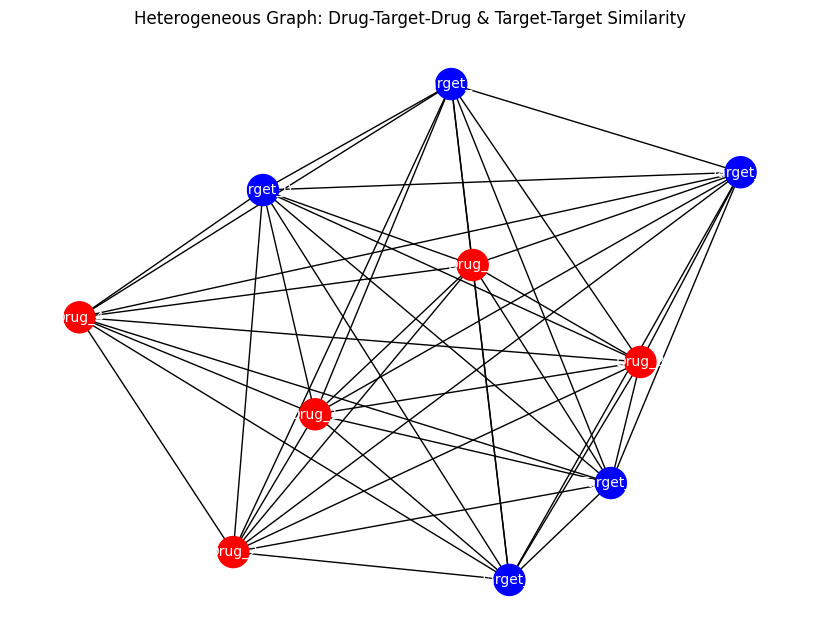

In [16]:
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Sample embedding matrices for drugs and proteins (targets)
# Let's create random embedding vectors for 5 drugs and 5 targets as a sample.
drug_embeddings = np.random.rand(5, 100)  # 5 drugs, 100-dimensional embeddings
target_embeddings = np.random.rand(5, 100)  # 5 targets, 100-dimensional embeddings

# Step 2: Compute Cosine Similarity for Drugs and Targets
DD_Sim = cosine_similarity(drug_embeddings)
TT_Sim = cosine_similarity(target_embeddings)

# Step 3: Apply filtering thresholds to drug-drug and target-target similarities
drug_similarity_threshold = 0.3
target_similarity_threshold = 0.04

# Filter similarity matrices
DD_Sim_filtered = np.where(DD_Sim > drug_similarity_threshold, DD_Sim, 0)
TT_Sim_filtered = np.where(TT_Sim > target_similarity_threshold, TT_Sim, 0)

# Step 4: Create the heterogeneous graph G(V, E) with drugs, targets, and similarities
G = nx.Graph()

# Step 5: Add drug and target nodes
for i in range(drug_embeddings.shape[0]):
    G.add_node(f'Drug_{i}', type='drug')

for j in range(target_embeddings.shape[0]):
    G.add_node(f'Target_{j}', type='target')

# Step 6: Add edges between drugs and targets (D-T edges) with random binding strengths
# Let's simulate random drug-target binding affinity values for each drug-target pair
binding_affinities = np.random.rand(drug_embeddings.shape[0], target_embeddings.shape[0])

for i in range(drug_embeddings.shape[0]):
    for j in range(target_embeddings.shape[0]):
        G.add_edge(f'Drug_{i}', f'Target_{j}', weight=binding_affinities[i, j], type='D-T')

# Step 7: Add drug-drug edges (D-D edges) based on filtered drug similarity
for i in range(DD_Sim_filtered.shape[0]):
    for j in range(i+1, DD_Sim_filtered.shape[1]):
        if DD_Sim_filtered[i, j] > 0:
            G.add_edge(f'Drug_{i}', f'Drug_{j}', weight=DD_Sim_filtered[i, j], type='D-D')

# Step 8: Add target-target edges (T-T edges) based on filtered target similarity
for i in range(TT_Sim_filtered.shape[0]):
    for j in range(i+1, TT_Sim_filtered.shape[1]):
        if TT_Sim_filtered[i, j] > 0:
            G.add_edge(f'Target_{i}', f'Target_{j}', weight=TT_Sim_filtered[i, j], type='T-T')

# Step 9: Output the graph info (corrected to avoid deprecated nx.info())
print("Graph G Info:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Print some node and edge attributes
print("\nNode types:")
for node in G.nodes(data=True):
    print(f"Node: {node[0]}, Type: {node[1]['type']}")

print("\nEdge types:")
for edge in G.edges(data=True):
    print(f"Edge: {edge[0]} <-> {edge[1]}, Type: {edge[2]['type']}, Weight: {edge[2]['weight']}")

# Step 10: Visualize the heterogeneous graph (optional)
import matplotlib.pyplot as plt

# Set node colors: red for drugs, blue for targets
node_colors = ['red' if G.nodes[node]['type'] == 'drug' else 'blue' for node in G.nodes()]

plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color=node_colors, node_size=500, font_size=10, font_color='white')
plt.title("Heterogeneous Graph: Drug-Target-Drug & Target-Target Similarity")
plt.show()


Graph G Info:
Number of nodes: 6
Number of edges: 15

Node types:
Node: Drug_1, Type: drug
Node: Drug_2, Type: drug
Node: Drug_3, Type: drug
Node: Target_1, Type: target
Node: Target_2, Type: target
Node: Target_3, Type: target

Edge types:
Edge: Drug_1 <-> Drug_2, Type: D-D, Weight: 0.8
Edge: Drug_1 <-> Drug_3, Type: D-D, Weight: 0.2
Edge: Drug_1 <-> Target_1, Type: D-T, Weight: 0.9
Edge: Drug_1 <-> Target_2, Type: D-T, Weight: 0.3
Edge: Drug_1 <-> Target_3, Type: D-T, Weight: 0.1
Edge: Drug_2 <-> Drug_3, Type: D-D, Weight: 0.5
Edge: Drug_2 <-> Target_1, Type: D-T, Weight: 0.4
Edge: Drug_2 <-> Target_2, Type: D-T, Weight: 0.8
Edge: Drug_2 <-> Target_3, Type: D-T, Weight: 0.7
Edge: Drug_3 <-> Target_1, Type: D-T, Weight: 0.2
Edge: Drug_3 <-> Target_2, Type: D-T, Weight: 0.6
Edge: Drug_3 <-> Target_3, Type: D-T, Weight: 0.9
Edge: Target_1 <-> Target_2, Type: T-T, Weight: 0.6
Edge: Target_1 <-> Target_3, Type: T-T, Weight: 0.3
Edge: Target_2 <-> Target_3, Type: T-T, Weight: 0.4


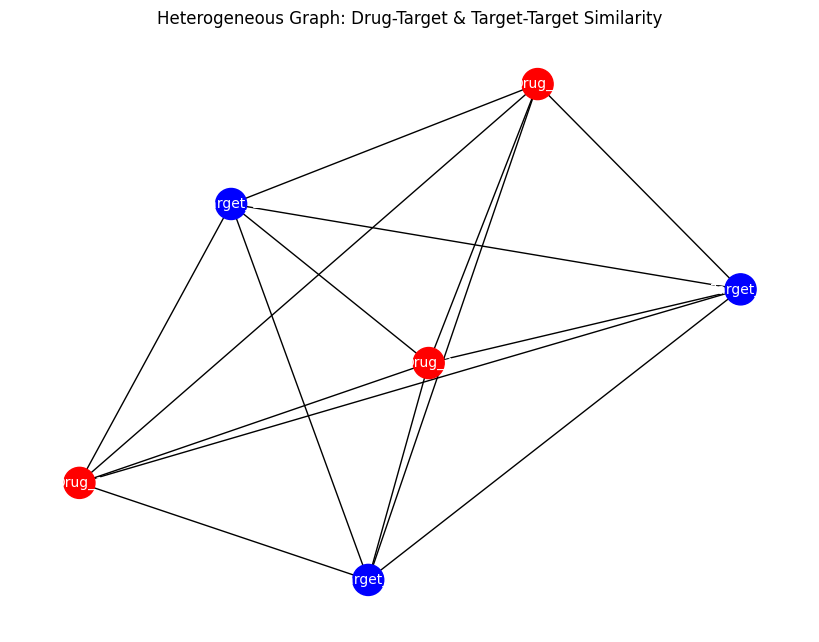

In [17]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Step 1: Create sample drug-drug similarity matrix (3x3)
DD_Sim = np.array([
    [1.0, 0.8, 0.2],  # Drug 1
    [0.8, 1.0, 0.5],  # Drug 2
    [0.2, 0.5, 1.0]   # Drug 3
])

# Step 2: Create sample drug-target binding affinity matrix (3x3)
DT_Binding_Affinity = np.array([
    [0.9, 0.3, 0.1],  # Drug 1 affinities to Target 1, 2, 3
    [0.4, 0.8, 0.7],  # Drug 2 affinities to Target 1, 2, 3
    [0.2, 0.6, 0.9]   # Drug 3 affinities to Target 1, 2, 3
])

# Step 3: Create sample target-target binding affinity matrix (3x3)
TTBA_Sim = np.array([
    [1.0, 0.6, 0.3],  # Target 1
    [0.6, 1.0, 0.4],  # Target 2
    [0.3, 0.4, 1.0]   # Target 3
])

# Step 4: Create the heterogeneous graph G(V, E)
G = nx.Graph()

# Step 5: Add drug nodes
for i in range(DD_Sim.shape[0]):
    G.add_node(f'Drug_{i+1}', type='drug')

# Step 6: Add target nodes
for j in range(TTBA_Sim.shape[0]):
    G.add_node(f'Target_{j+1}', type='target')

# Step 7: Add drug-drug edges (D-D edges) based on DD_Sim
for i in range(DD_Sim.shape[0]):
    for j in range(i + 1, DD_Sim.shape[1]):
        if DD_Sim[i, j] > 0:  # Only add edge if similarity > 0
            G.add_edge(f'Drug_{i+1}', f'Drug_{j+1}', weight=DD_Sim[i, j], type='D-D')

# Step 8: Add drug-target edges (D-T edges) based on DT_Binding_Affinity
for i in range(DT_Binding_Affinity.shape[0]):
    for j in range(DT_Binding_Affinity.shape[1]):
        if DT_Binding_Affinity[i, j] > 0:  # Only add edge if binding affinity > 0
            G.add_edge(f'Drug_{i+1}', f'Target_{j+1}', weight=DT_Binding_Affinity[i, j], type='D-T')

# Step 9: Add target-target edges (T-T edges) based on TTBA_Sim
for i in range(TTBA_Sim.shape[0]):
    for j in range(i + 1, TTBA_Sim.shape[1]):
        if TTBA_Sim[i, j] > 0:  # Only add edge if similarity > 0
            G.add_edge(f'Target_{i+1}', f'Target_{j+1}', weight=TTBA_Sim[i, j], type='T-T')

# Step 10: Output the graph info
print("Graph G Info:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Print node and edge attributes
print("\nNode types:")
for node in G.nodes(data=True):
    print(f"Node: {node[0]}, Type: {node[1]['type']}")

print("\nEdge types:")
for edge in G.edges(data=True):
    print(f"Edge: {edge[0]} <-> {edge[1]}, Type: {edge[2]['type']}, Weight: {edge[2]['weight']}")

# Step 11: Visualize the heterogeneous graph (optional)
node_colors = ['red' if G.nodes[node]['type'] == 'drug' else 'blue' for node in G.nodes()]
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color=node_colors, node_size=500, font_size=10, font_color='white')
plt.title("Heterogeneous Graph: Drug-Target & Target-Target Similarity")
plt.show()


##### ----------------------------------- END of the CODE -----------------------------------